<a href="https://colab.research.google.com/github/RutujKhare1/CS6910_Assignment_1/blob/main/FDL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
num_label = 10
num_samples = len(X_train)

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print("Train shape : {}, {}".format(X_train.shape, y_train.shape))
print("Test shape : {}, {}".format(X_test.shape, y_test.shape))

Train shape : (60000, 28, 28), (60000,)
Test shape : (10000, 28, 28), (10000,)


# Question 1

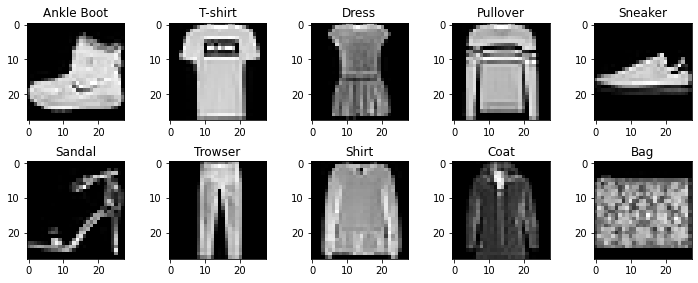

In [4]:
num_row = 2
num_col = 5

cnt = 30
images = X_train[:cnt]
labels = y_train[:cnt]
dic = {0:'T-shirt', 1:'Trowser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

visited = [True for i in range(10)]
r_idx = 0
c_idx = 0
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col, 2*num_row))
for i in range(cnt):
  if(visited[labels[i]]):
    if(c_idx == num_col):
      r_idx = 1
      c_idx = 0
    visited[labels[i]] = False
    ax = axes[r_idx, c_idx]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('{}'.format(dic[labels[i]]))
    c_idx += 1 
plt.tight_layout()
plt.show()

#Question 2

In [5]:
#activation functions

def sigmoid(x):
  return 1/(1+np.exp(-x))

def softmax(x):
  e_x = np.exp(x - max(x))
  return e_x / e_x.sum()


In [13]:
# num_layers = 5
# hidden_size = 4
# num_labels = num_label
# xdim = 60000
# ydim = 784
# w = list()
# b = list()
# w.append(np.random.rand(ydim, hidden_size))
# b.append(np.random.rand(hidden_size))
# for i in range(num_layers-1):
#   w.append(np.random.rand(hidden_size, hidden_size))
#   b.append(np.random.rand(hidden_size))
# w.append(np.random.rand(hidden_size, num_labels))
# b.append(num_labels)
# X = np.reshape(X_train, (60000,784))
# W = w
# B = b

In [25]:
# cur_op = np.array([W[0].T@x + B[0] for x in X])
# cur_op = sigmoid(cur_op)
# cur_ip = cur_op
# print(cur_ip.shape)

# for i in range(num_layers-1):
#   cur_op =  np.array([W[i+1].T@x + B[i+1] for x in cur_ip])
#   cur_op = sigmoid(cur_op)
#   cur_ip = cur_op

# cur_op = np.array([W[num_layers].T@x + B[num_layers] for x in cur_ip])
# cur_op = np.array([softmax(i) for i in cur_op])
# print(cur_op.shape)

(60000, 4)
(60000, 10)


In [13]:
X = np.reshape(X_train, (60000,784))
class feedforwardNeuralNetwork:
  def __init__(self, num_layers = 5, hidden_size = 4, xdim = 60000, ydim = 784, num_labels = 10):
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.xdim = xdim
    self.ydim = ydim
    self.num_labels = num_labels
    w = list()
    b = list()
    w.append(np.random.rand(ydim, hidden_size))
    b.append(np.random.rand(hidden_size))
    for i in range(num_layers-1):
      w.append(np.random.rand(hidden_size, hidden_size))
      b.append(np.random.rand(hidden_size))
    w.append(np.random.rand(hidden_size, num_labels))
    b.append(num_labels)
    self.W = w
    self.B = b
  
  def feedForward(self):
    cur_op = np.array([self.W[0].T@x + self.B[0] for x in X])
    cur_op = sigmoid(cur_op)
    cur_ip = cur_op
    # print(cur_ip.shape)

    for i in range(self.num_layers-1):
      cur_op =  np.array([self.W[i+1].T@x + self.B[i+1] for x in cur_ip])
      cur_op = sigmoid(cur_op)
      cur_ip = cur_op

    cur_op = np.array([self.W[self.num_layers].T@x + self.B[self.num_layers] for x in cur_ip])
    cur_op = np.array([softmax(i) for i in cur_op])
    print(cur_op.shape)
      
    
    

In [14]:
F = feedforwardNeuralNetwork()
F.feedForward()

(60000, 10)
